In [1]:
#2
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics
import warnings
#3
from gensim.downloader import load
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
import time
import json
import pickle
import os.path
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26565\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_json('goemotions.json')
df.columns = ['post', 'emotion', 'sentiment']

In [3]:
df.head()

,post,emotion,sentiment
0,That game hurt.,sadness,negative
1,"You do right, if you don't care then fuck 'em!",neutral,neutral
2,Man I love reddit.,love,positive
3,"[NAME] was nowhere near them, he was by the Fa...",neutral,neutral
4,Right? Considering it’s such an important docu...,gratitude,positive


In [4]:
file=pd.read_json('goemotions.json')
emotion= file[1].value_counts()
print(emotion)
sentiment = file[2].value_counts()
print(sentiment)

neutral           55298
approval          11259
admiration        10531
annoyance          8342
disapproval        7686
gratitude          7075
amusement          6130
curiosity          5885
anger              5202
love               4957
confusion          4938
realization        4714
disappointment     4706
optimism           4519
joy                4329
sadness            3827
caring             3523
surprise           3472
excitement         3020
disgust            2914
desire             2147
fear               1778
remorse            1510
embarrassment      1433
nervousness         796
relief              788
pride               690
grief               351
Name: 1, dtype: int64
positive     58968
neutral      55298
negative     38545
ambiguous    19009
Name: 2, dtype: int64


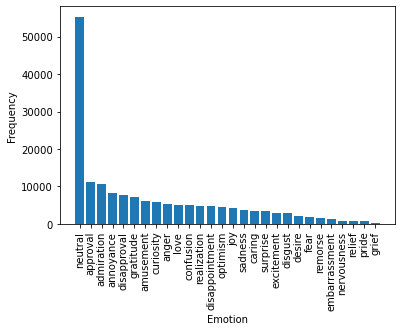

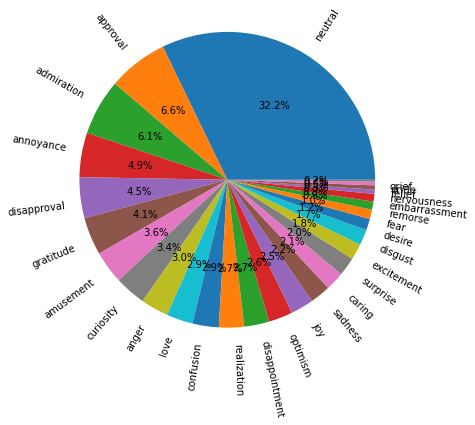

In [5]:
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(emotion.keys(),emotion)
plt.savefig("emotion_bar.pdf")
plt.show()

e=[]
s=[]
for key,value in emotion.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.savefig("emotion_pie.pdf")
plt.show()


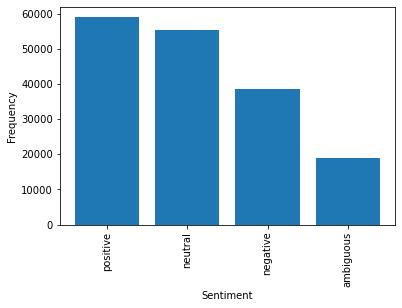

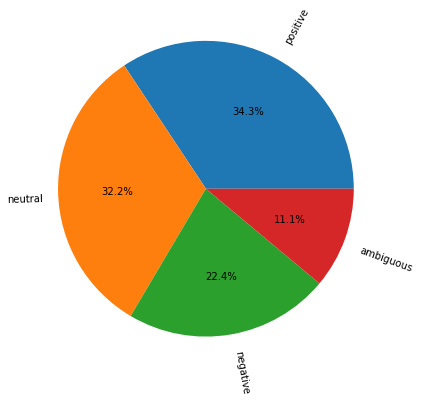

In [6]:
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(sentiment.keys(),sentiment)
plt.savefig("sentiment_bar.pdf")
plt.show()

e=[]
s=[]
for key,value in sentiment.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.savefig("sentiment_pie.pdf")
plt.show()


### 2.1. Process the dataset using feature_extraction.text.CountVectorizer to extract tokens/words and their frequencies.

In [7]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.post)

In [8]:
print(X.shape)
print(df.shape)

(171820, 30449)
(171820, 3)


### 2.2. Split the dataset into 80% for training and 20% for testing. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, df[['emotion', 'sentiment']], test_size=0.2)
print(X_train.shape)

(137456, 30449)


### 2.3. Train and test the following classifiers, for both the emotion and the sentiment classification, using word frequency as features.

In [10]:
performance_data = []
def train_model(model, model_name):
    for label in ['emotion', 'sentiment']:
        start=time.time()
        print(f'{label} train {label} start: {start}')
        
        if (os.path.exists(f'trainedmodels/{model_name}_{label}_model.pickle')):
            picklefile = open(f'trainedmodels/{model_name}_{label}_model.pickle','rb')
            model = pickle.load(picklefile)
            print(f"success load pretrainedmodel: trainedmodels/{model_name}_{label}_model.pickle")
        else:
            model = model.fit(X_train, y_train[label])
            with open(f'trainedmodels/{model_name}_{label}_model.pickle','wb') as f:
                pickle.dump(model, f)

            pickle_in = open(f'trainedmodels/{model_name}_{label}_model.pickle','rb')
            model = pickle.load(pickle_in)
        
        end=time.time()
        print(f'{label} train {label} end: {end} take time:{end-start}')
        start=time.time()
        y_pred = model.predict(X_test)
        end=time.time()
        print(f'{label} predict {label} end: {end} take time:{end-start}')
        performance_data.append([f'{model_name}, {label}', confusion_matrix(y_test[label], y_pred), classification_report(y_test[label], y_pred)])

In [11]:
def grid_search(model, model_name, params):
    clf = GridSearchCV(model, params, cv=2, n_jobs=-1)
    for label in ['emotion', 'sentiment']:
        
        if (os.path.exists(f'trainedGridSearchCV/{model_name}_{label}_model.pickle')):
            picklefile = open(f'trainedGridSearchCV/{model_name}_{label}_model.pickle','rb')
            clf = pickle.load(picklefile)
            print(f"success load pretrainedGridSearchCV: trainedGridSearchCV/{model_name}_{label}_model.pickle")
        else:
            clf.fit(X_train, y_train[label])
            with open(f'trainedGridSearchCV/{model_name}_{label}_model.pickle','wb') as f:
                pickle.dump(clf, f)

            pickle_in = open(f'trainedGridSearchCV/{model_name}_{label}_model.pickle','rb')
            clf = pickle.load(pickle_in)
        
        param_str = ''
        for k, v in clf.best_params_.items():
            param_str += "{0}_{1}".format(k,v)
        y_pred = clf.best_estimator_.predict(X_test)
        performance_data.append([f"{model_name}, {param_str[:-1]}, {label}", confusion_matrix(y_test[label], y_pred), classification_report(y_test[label], y_pred)])

In [12]:
def performance_data_show(train_y,predict_y,model_type,model_name,y_name):
    print(f"F1 Score (W): {sklearn.metrics.f1_score(y_true=train_y,y_pred= predict_y,average='weighted')}")
    print(f"F1 Score (M): {sklearn.metrics.f1_score(y_true=train_y,y_pred= predict_y,average='macro')}")
    
    print(f"Accuracy: {sklearn.metrics.accuracy_score(y_true=train_y,y_pred= predict_y)}")
    print(f"Precision (W): {sklearn.metrics.precision_score(y_true=train_y,y_pred= predict_y, average='weighted')}")
    
    confusion_matrix(y_true=train_y,y_pred= predict_y)
    print(classification_report(y_true=train_y,y_pred= predict_y, zero_division='warn'))
    cmp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix(y_true=train_y,y_pred= predict_y))
    fig, ax = plt.subplots(figsize=(14,14))
    cmp.plot(ax=ax,cmap='Blues',colorbar='coolwarm')
    plt.savefig(f"plotpic/{model_type}_{model_name}_{y_name}.jpg")

#### 2.3.1. Base-MNB: a Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) with the default parameters.

In [13]:
base_mnb = MultinomialNB()
train_model(base_mnb, 'MultinomialNB')

emotion train emotion start: 1666553479.534583
success load pretrainedmodel: trainedmodels/MultinomialNB_emotion_model.pickle
emotion train emotion end: 1666553479.5764523 take time:0.041869163513183594
emotion predict emotion end: 1666553479.5963995 take time:0.019947290420532227
sentiment train sentiment start: 1666553480.8261125
success load pretrainedmodel: trainedmodels/MultinomialNB_sentiment_model.pickle
sentiment train sentiment end: 1666553480.8301017 take time:0.003989219665527344
sentiment predict sentiment end: 1666553480.837083 take time:0.006981372833251953


test for emotion:
F1 Score (W): 0.3672337721093812
F1 Score (M): 0.2217391876238735
Accuracy: 0.434990105924805
Precision (W): 0.4824964740391358
                precision    recall  f1-score   support

    admiration       0.55      0.52      0.54      2088
     amusement       0.64      0.35      0.45      1256
         anger       0.53      0.19      0.28      1057
     annoyance       0.41      0.15      0.22      1669
      approval       0.42      0.17      0.25      2203
        caring       0.51      0.11      0.19       748
     confusion       0.54      0.11      0.18       986
     curiosity       0.51      0.14      0.23      1170
        desire       0.67      0.07      0.12       452
disappointment       0.46      0.07      0.12       937
   disapproval       0.46      0.14      0.22      1544
       disgust       0.57      0.10      0.17       576
 embarrassment       0.62      0.04      0.07       276
    excitement       0.55      0.06      0.10       619
          fea

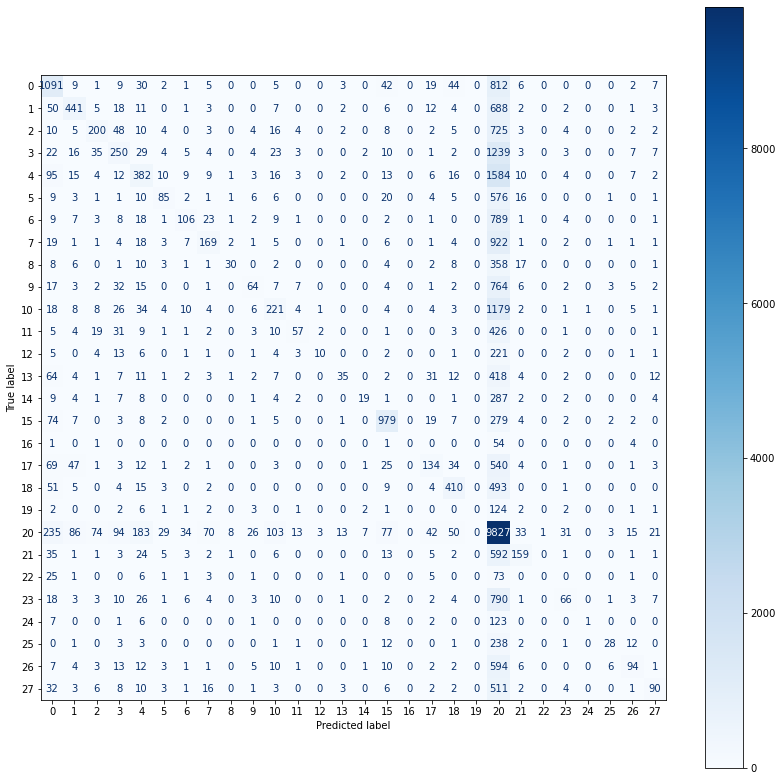

In [14]:
model_typeN='trainedmodels'
model_nameN='MultinomialNB'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.6013691065212221
F1 Score (M): 0.5687329546672967
Accuracy: 0.6081364218368059
Precision (W): 0.6034752846575681
              precision    recall  f1-score   support

   ambiguous       0.56      0.33      0.41      3821
    negative       0.61      0.59      0.60      7703
     neutral       0.56      0.56      0.56     11078
    positive       0.66      0.75      0.70     11762

    accuracy                           0.61     34364
   macro avg       0.60      0.56      0.57     34364
weighted avg       0.60      0.61      0.60     34364



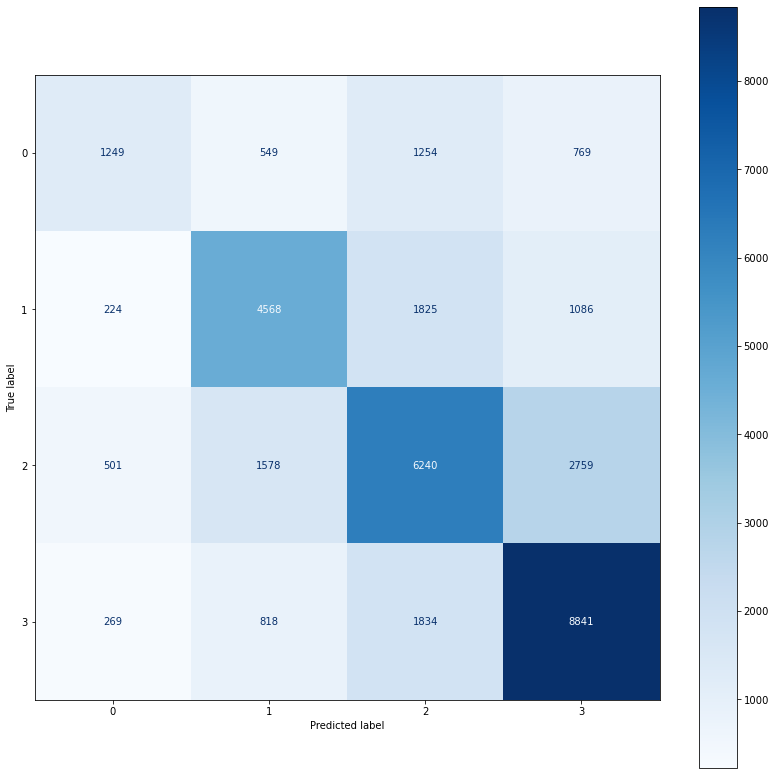

In [15]:
model_typeN='trainedmodels'
model_nameN='MultinomialNB'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.2. Base-DT: a Decision Tree (tree.DecisionTreeClassifier) with the default parameters

In [16]:
base_dt = DecisionTreeClassifier()
train_model(base_dt, 'DecisionTreeClassifier')

emotion train emotion start: 1666553490.4644406
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_emotion_model.pickle
emotion train emotion end: 1666553490.5362847 take time:0.07184410095214844
emotion predict emotion end: 1666553490.5821598 take time:0.04587507247924805
sentiment train sentiment start: 1666553492.0941188
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_sentiment_model.pickle
sentiment train sentiment end: 1666553492.1069627 take time:0.012843847274780273
sentiment predict sentiment end: 1666553492.136882 take time:0.02991938591003418


test for emotion:
F1 Score (W): 0.5900680933288325
F1 Score (M): 0.517346460320759
Accuracy: 0.5935281108136422
Precision (W): 0.6086920863995283
                precision    recall  f1-score   support

    admiration       0.58      0.82      0.68      2088
     amusement       0.58      0.82      0.68      1256
         anger       0.47      0.71      0.57      1057
     annoyance       0.41      0.59      0.49      1669
      approval       0.44      0.56      0.49      2203
        caring       0.49      0.58      0.53       748
     confusion       0.49      0.57      0.53       986
     curiosity       0.55      0.58      0.56      1170
        desire       0.52      0.53      0.52       452
disappointment       0.44      0.45      0.44       937
   disapproval       0.54      0.49      0.51      1544
       disgust       0.56      0.43      0.48       576
 embarrassment       0.48      0.36      0.41       276
    excitement       0.56      0.46      0.51       619
          fea

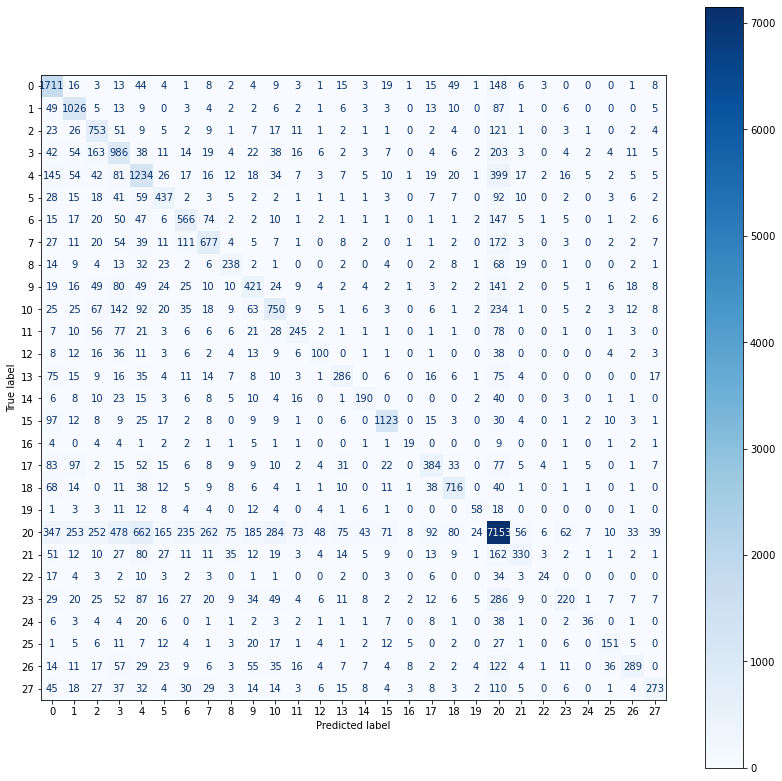

In [17]:
model_typeN='trainedmodels'
model_nameN='DecisionTreeClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.7191144683689241
F1 Score (M): 0.7031051665896968
Accuracy: 0.7167966476545222
Precision (W): 0.728193338899006
              precision    recall  f1-score   support

   ambiguous       0.56      0.71      0.62      3821
    negative       0.68      0.78      0.72      7703
     neutral       0.71      0.66      0.68     11078
    positive       0.84      0.73      0.78     11762

    accuracy                           0.72     34364
   macro avg       0.69      0.72      0.70     34364
weighted avg       0.73      0.72      0.72     34364



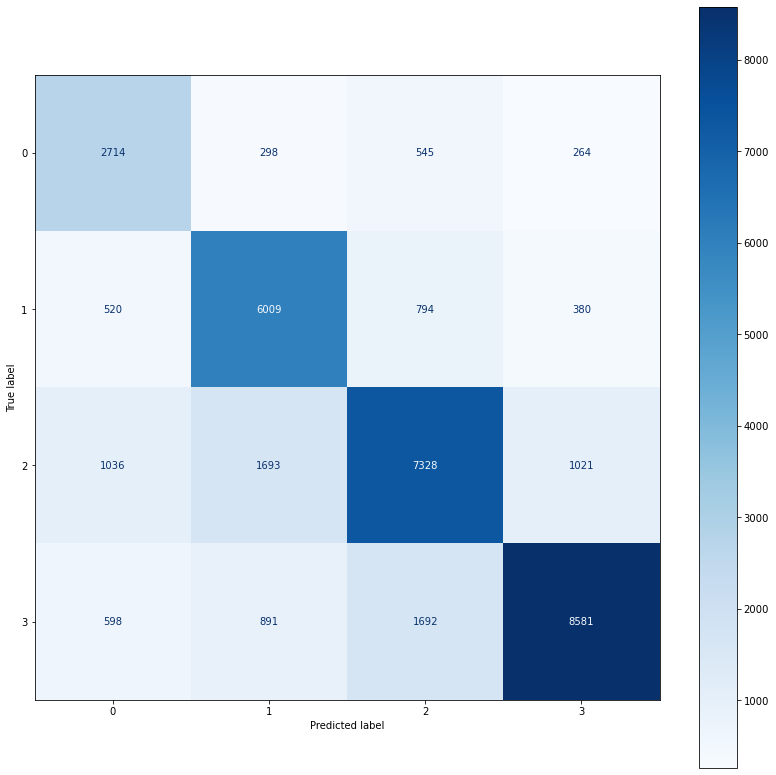

In [18]:
model_typeN='trainedmodels'
model_nameN='DecisionTreeClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.3. Base-MLP: a Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.

In [19]:
base_mlp = MLPClassifier(max_iter=2)
train_model(base_mlp, 'MLPClassifier')

emotion train emotion start: 1666553502.0642376
success load pretrainedmodel: trainedmodels/MLPClassifier_emotion_model.pickle
emotion train emotion end: 1666553502.1481023 take time:0.08386468887329102
emotion predict emotion end: 1666553502.219908 take time:0.07180571556091309
sentiment train sentiment start: 1666553503.5254164
success load pretrainedmodel: trainedmodels/MLPClassifier_sentiment_model.pickle
sentiment train sentiment end: 1666553503.582265 take time:0.05684852600097656
sentiment predict sentiment end: 1666553503.6530764 take time:0.07081151008605957


test for emotion:
F1 Score (W): 0.4691171433829688
F1 Score (M): 0.3688237646377684
Accuracy: 0.507391456175067
Precision (W): 0.505999390637638
                precision    recall  f1-score   support

    admiration       0.61      0.61      0.61      2088
     amusement       0.61      0.67      0.64      1256
         anger       0.51      0.38      0.44      1057
     annoyance       0.40      0.17      0.24      1669
      approval       0.45      0.20      0.28      2203
        caring       0.46      0.22      0.30       748
     confusion       0.51      0.23      0.32       986
     curiosity       0.51      0.25      0.34      1170
        desire       0.54      0.28      0.37       452
disappointment       0.45      0.13      0.20       937
   disapproval       0.42      0.22      0.29      1544
       disgust       0.51      0.27      0.36       576
 embarrassment       0.53      0.21      0.30       276
    excitement       0.56      0.18      0.28       619
          fear

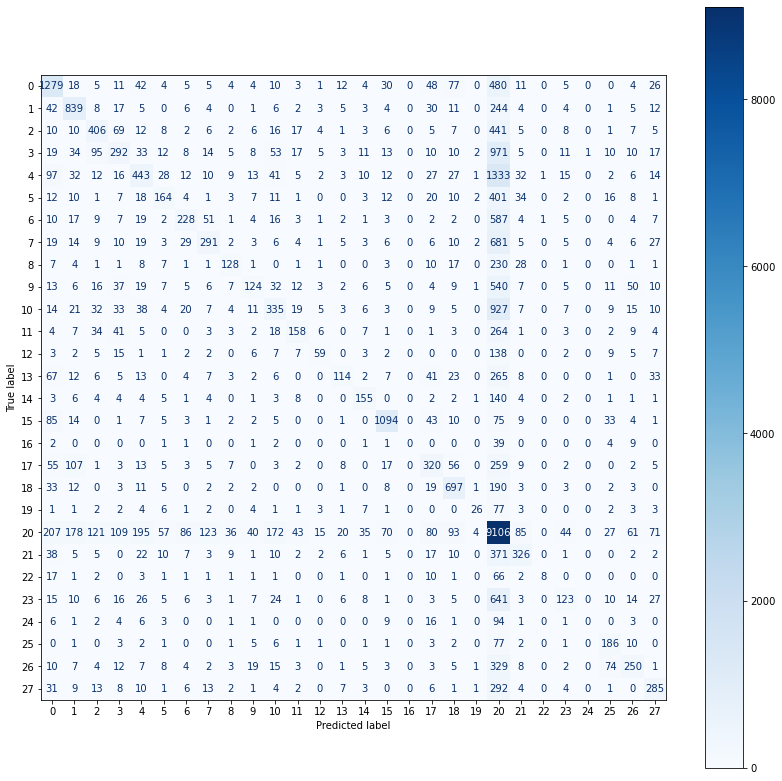

In [20]:
model_typeN='trainedmodels'
model_nameN='MLPClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.647464919955244
F1 Score (M): 0.6146476243162504
Accuracy: 0.6511465487137702
Precision (W): 0.6563661084104959
              precision    recall  f1-score   support

   ambiguous       0.60      0.38      0.47      3821
    negative       0.70      0.56      0.62      7703
     neutral       0.57      0.70      0.62     11078
    positive       0.73      0.75      0.74     11762

    accuracy                           0.65     34364
   macro avg       0.65      0.60      0.61     34364
weighted avg       0.66      0.65      0.65     34364



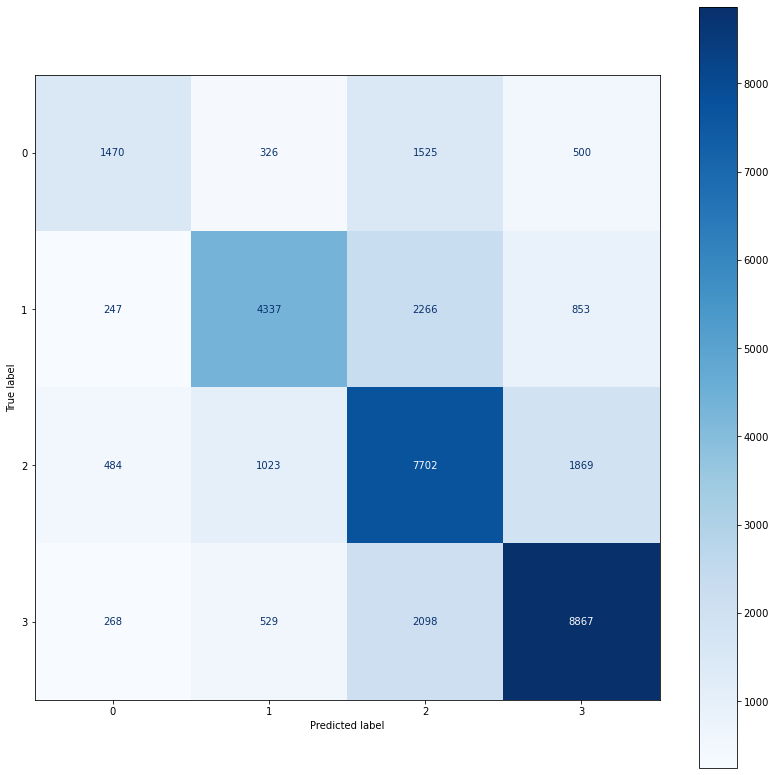

In [21]:
model_typeN='trainedmodels'
model_nameN='MLPClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.4. Top-MNB: a better performing Multinomial Naive Bayes Classifier found using GridSearchCV

In [22]:
mnb_params = {'alpha': [0.5, 0, 2]}
grid_search(base_mnb, 'MultinomialNB', mnb_params)

success load pretrainedGridSearchCV: trainedGridSearchCV/MultinomialNB_emotion_model.pickle
success load pretrainedGridSearchCV: trainedGridSearchCV/MultinomialNB_sentiment_model.pickle


test for emotion:
F1 Score (W): 0.43766887216639794
F1 Score (M): 0.32146097286145825
Accuracy: 0.4733150971947387
Precision (W): 0.4811466601589672
                precision    recall  f1-score   support

    admiration       0.53      0.61      0.56      2088
     amusement       0.62      0.56      0.58      1256
         anger       0.48      0.32      0.38      1057
     annoyance       0.38      0.22      0.28      1669
      approval       0.41      0.24      0.30      2203
        caring       0.39      0.23      0.29       748
     confusion       0.45      0.20      0.28       986
     curiosity       0.48      0.26      0.34      1170
        desire       0.53      0.16      0.24       452
disappointment       0.42      0.16      0.23       937
   disapproval       0.42      0.25      0.32      1544
       disgust       0.50      0.21      0.30       576
 embarrassment       0.59      0.11      0.18       276
    excitement       0.55      0.16      0.25       619
          

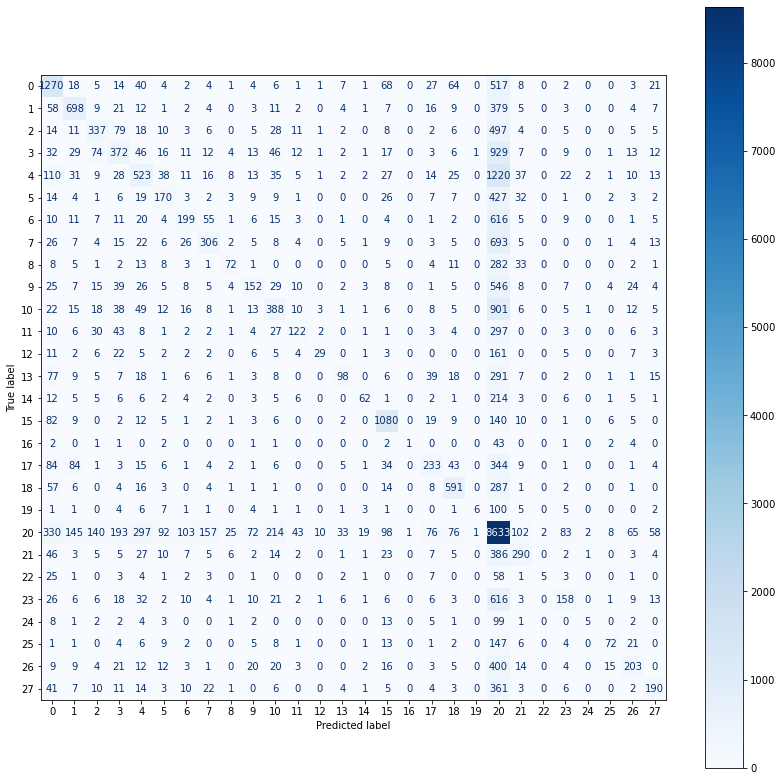

In [23]:
model_typeN='trainedGridSearchCV'
model_nameN='MultinomialNB'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.6094124858573083
F1 Score (M): 0.5837251828989938
Accuracy: 0.6133453614247468
Precision (W): 0.6085930901600597
              precision    recall  f1-score   support

   ambiguous       0.53      0.41      0.46      3821
    negative       0.61      0.61      0.61      7703
     neutral       0.57      0.55      0.56     11078
    positive       0.67      0.74      0.70     11762

    accuracy                           0.61     34364
   macro avg       0.59      0.58      0.58     34364
weighted avg       0.61      0.61      0.61     34364



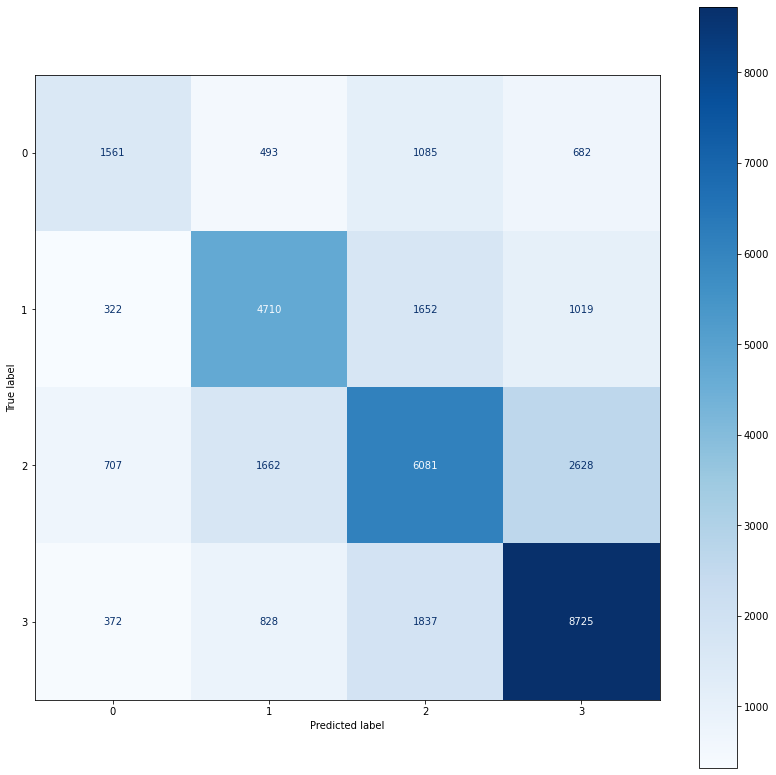

In [24]:
model_typeN='trainedGridSearchCV'
model_nameN='MultinomialNB'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.5. Top-DT: a better performing Decision Tree found using GridSearchCV. 

In [25]:
dt_params = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 3],
             'min_samples_split': [2, 3, 4]}
grid_search(base_dt, 'DecisionTreeClassifier', dt_params)

success load pretrainedGridSearchCV: trainedGridSearchCV/DecisionTreeClassifier_emotion_model.pickle
success load pretrainedGridSearchCV: trainedGridSearchCV/DecisionTreeClassifier_sentiment_model.pickle


test for emotion:
F1 Score (W): 0.21203938551135124
F1 Score (M): 0.06742948033819159
Accuracy: 0.3648294727039926
Precision (W): 0.16060009666388989
                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00      2088
     amusement       0.00      0.00      0.00      1256
         anger       0.00      0.00      0.00      1057
     annoyance       0.00      0.00      0.00      1669
      approval       0.00      0.00      0.00      2203
        caring       0.00      0.00      0.00       748
     confusion       0.00      0.00      0.00       986
     curiosity       0.00      0.00      0.00      1170
        desire       0.00      0.00      0.00       452
disappointment       0.00      0.00      0.00       937
   disapproval       0.00      0.00      0.00      1544
       disgust       0.00      0.00      0.00       576
 embarrassment       0.00      0.00      0.00       276
    excitement       0.00      0.00      0.00       619
         

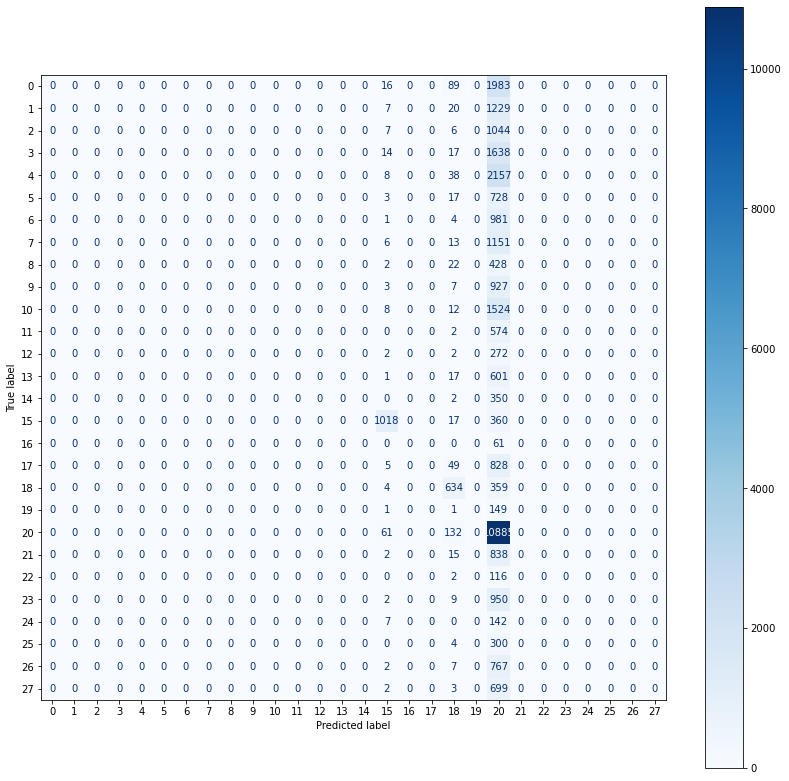

In [26]:
model_typeN='trainedGridSearchCV'
model_nameN='DecisionTreeClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.2596590035440406
F1 Score (M): 0.19699686719010184
Accuracy: 0.37481084856244906
Precision (W): 0.4034366954623935
              precision    recall  f1-score   support

   ambiguous       0.00      0.00      0.00      3821
    negative       0.00      0.00      0.00      7703
     neutral       0.34      0.98      0.50     11078
    positive       0.86      0.17      0.28     11762

    accuracy                           0.37     34364
   macro avg       0.30      0.29      0.20     34364
weighted avg       0.40      0.37      0.26     34364



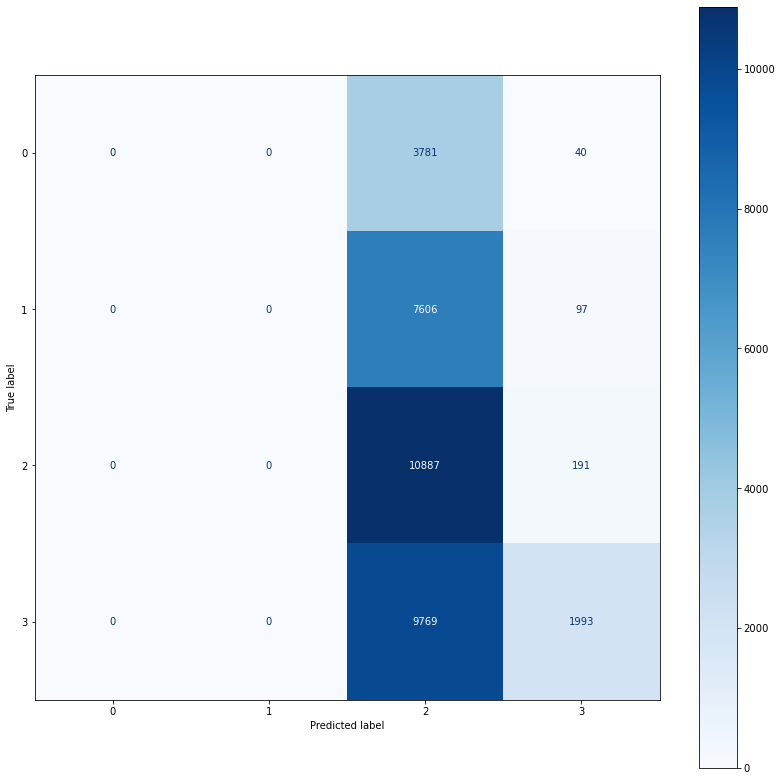

In [27]:
model_typeN='trainedGridSearchCV'
model_nameN='DecisionTreeClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

#### 2.3.6. Top-MLP: a better performing Multi-Layered Perceptron found using GridSearchCV.

In [28]:
mlp_params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes': [(30, 50), (10, 10, 10)],
              'solver': ['adam', 'sgd']}
grid_search(base_mlp, 'MLPClassifier', mlp_params)

success load pretrainedGridSearchCV: trainedGridSearchCV/MLPClassifier_emotion_model.pickle
success load pretrainedGridSearchCV: trainedGridSearchCV/MLPClassifier_sentiment_model.pickle


test for emotion:
F1 Score (W): 0.45146001635634886
F1 Score (M): 0.34482748432285776
Accuracy: 0.49793388429752067
Precision (W): 0.5010426950099419
                precision    recall  f1-score   support

    admiration       0.60      0.60      0.60      2088
     amusement       0.58      0.69      0.63      1256
         anger       0.49      0.37      0.42      1057
     annoyance       0.39      0.17      0.23      1669
      approval       0.48      0.15      0.23      2203
        caring       0.45      0.22      0.30       748
     confusion       0.50      0.15      0.23       986
     curiosity       0.55      0.18      0.27      1170
        desire       0.50      0.30      0.38       452
disappointment       0.48      0.10      0.17       937
   disapproval       0.39      0.21      0.27      1544
       disgust       0.47      0.28      0.35       576
 embarrassment       0.47      0.22      0.30       276
    excitement       0.53      0.17      0.26       619
         

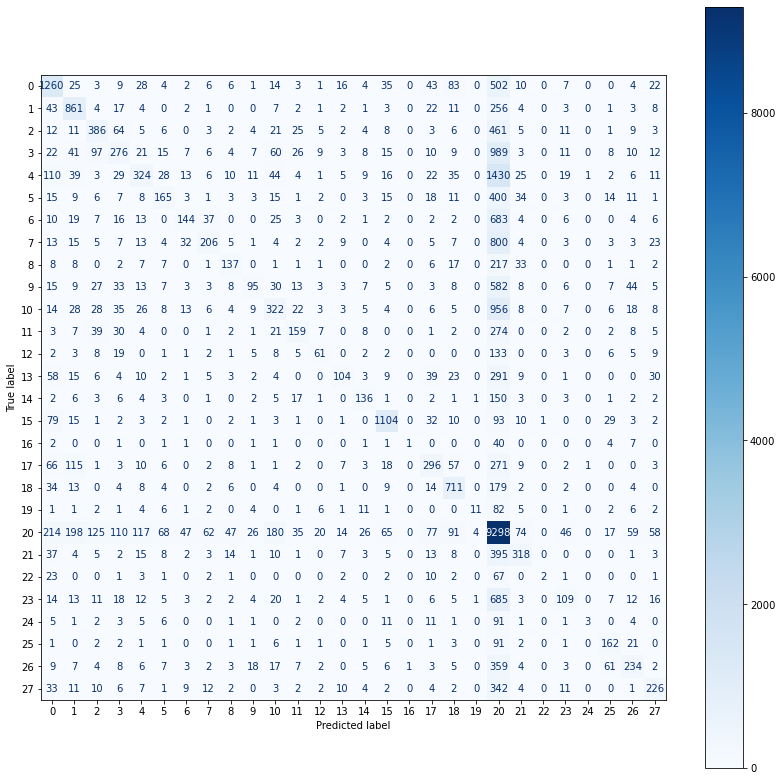

In [29]:
model_typeN='trainedGridSearchCV'
model_nameN='MLPClassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

test for sentiment:
F1 Score (W): 0.6252654617101031
F1 Score (M): 0.5882103523819106
Accuracy: 0.6296414852752881
Precision (W): 0.635595398392076
              precision    recall  f1-score   support

   ambiguous       0.60      0.32      0.42      3821
    negative       0.64      0.58      0.61      7703
     neutral       0.54      0.67      0.60     11078
    positive       0.73      0.72      0.73     11762

    accuracy                           0.63     34364
   macro avg       0.63      0.57      0.59     34364
weighted avg       0.64      0.63      0.63     34364



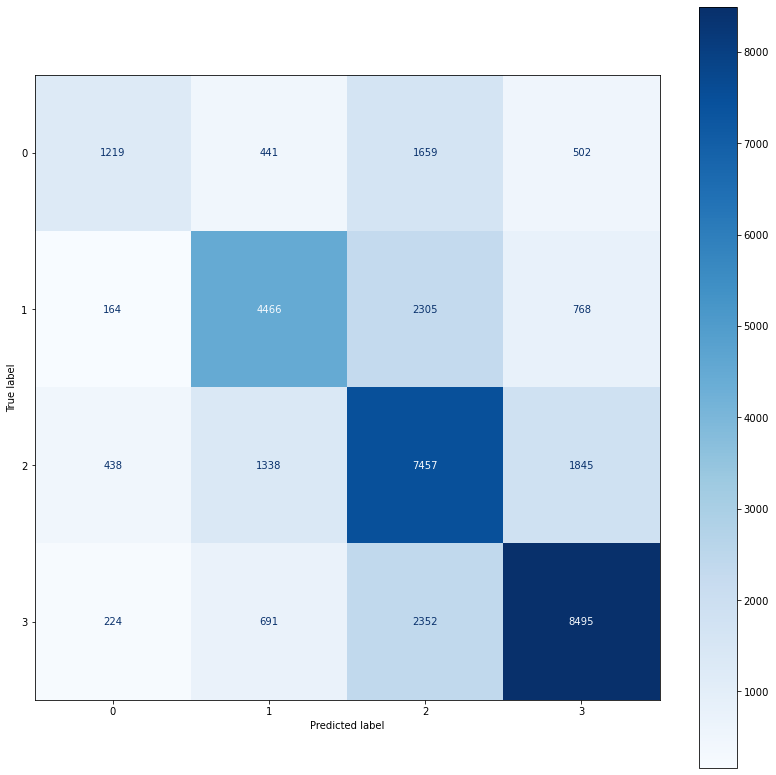

In [30]:
model_typeN='trainedGridSearchCV'
model_nameN='MLPClassifier'
y_name='sentiment'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test)
print(f'test for {y_name}:')
performance_data_show(y_test[y_name],y_pred,model_typeN,model_nameN,y_name)

### 2.4. For each of the 6 classifiers above and each of the classification tasks (emotion or sentiment), produce and save the following information in a file called performance.

In [31]:
with open('performance.txt', 'w') as f:
    for line in performance_data:
        line = list(map(str, line))
        f.write(",".join(line))

### 2.5. Use tf-idf instead of word frequencies and redo all substeps of 2.3 above – you can use TfidfTransformer for this. Display the results of this experiment.

In [32]:
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, df[['emotion', 'sentiment']], test_size=0.2)

In [33]:
performance_data = []
base_mnb = MultinomialNB()
train_model(base_mnb, 'MultinomialNB')

base_dt = DecisionTreeClassifier()
train_model(base_dt, 'DecisionTreeClassifier')

base_mlp = MLPClassifier(max_iter=2)
train_model(base_mlp, 'MLPClassifier')

grid_search(base_mnb, 'MultinomialNB', mnb_params)

grid_search(base_dt, 'DecisionTreeClassifier', dt_params)

grid_search(base_mlp, 'MLPClassifier', mlp_params)

emotion train emotion start: 1666553545.3841374
success load pretrainedmodel: trainedmodels/MultinomialNB_emotion_model.pickle
emotion train emotion end: 1666553545.3901238 take time:0.005986452102661133
emotion predict emotion end: 1666553545.4210458 take time:0.03092193603515625
sentiment train sentiment start: 1666553546.5779464
success load pretrainedmodel: trainedmodels/MultinomialNB_sentiment_model.pickle
sentiment train sentiment end: 1666553546.5809383 take time:0.002991914749145508
sentiment predict sentiment end: 1666553546.5869222 take time:0.005983829498291016
emotion train emotion start: 1666553547.723882
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_emotion_model.pickle
emotion train emotion end: 1666553547.739839 take time:0.015957117080688477
emotion predict emotion end: 1666553547.7737484 take time:0.03390932083129883
sentiment train sentiment start: 1666553549.0827417
success load pretrainedmodel: trainedmodels/DecisionTreeClassifier_sentiment_mod

In [34]:
pd.DataFrame(performance_data, columns=['Model', 'confusion matrix', 'classfication report'])

,Model,confusion matrix,classfication report
0,"MultinomialNB, emotion","[[1100, 13, 1, 5, 33, 4, 0, 6, 1, 2, 2, 1, 0, ...",precision recall f1-score ...
1,"MultinomialNB, sentiment","[[1215, 550, 1181, 807], [276, 4616, 1779, 111...",precision recall f1-score ...
2,"DecisionTreeClassifier, emotion","[[1767, 13, 4, 13, 71, 8, 1, 5, 3, 3, 3, 2, 0,...",precision recall f1-score ...
3,"DecisionTreeClassifier, sentiment","[[2672, 309, 489, 283], [573, 6036, 777, 401],...",precision recall f1-score ...
4,"MLPClassifier, emotion","[[1298, 25, 2, 10, 38, 8, 5, 11, 5, 2, 6, 1, 1...",precision recall f1-score ...
5,"MLPClassifier, sentiment","[[1437, 341, 1454, 521], [304, 4425, 2215, 843...",precision recall f1-score ...
6,"MultinomialNB, alpha_0., emotion","[[1292, 20, 3, 14, 43, 12, 3, 10, 3, 3, 4, 1, ...",precision recall f1-score ...
7,"MultinomialNB, alpha_0., sentiment","[[1481, 524, 1016, 732], [385, 4742, 1618, 104...",precision recall f1-score ...
8,"DecisionTreeClassifier, criterion_ginimax_dept...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",precision recall f1-score ...
9,"DecisionTreeClassifier, criterion_ginimax_dept...","[[0, 0, 3701, 52], [0, 0, 7693, 94], [0, 0, 10...",precision recall f1-score ...


### 3.1 use gensim.downloader.load to load the word2vec-google-news-300 pretrained embedding model


In [35]:
wordvec2model=load('word2vec-google-news-300')

In [36]:
wordvec2model.similar_by_vector('car')

[('vehicle', 0.7821096181869507),
 ('cars', 0.7423830032348633),
 ('SUV', 0.7160962224006653),
 ('minivan', 0.6907036304473877),
 ('truck', 0.6735789775848389),
 ('Car', 0.6677608489990234),
 ('Ford_Focus', 0.6673202514648438),
 ('Honda_Civic', 0.6626849174499512),
 ('Jeep', 0.651133120059967),
 ('pickup_truck', 0.6441437602043152)]

### 3.2 Use the tokenizer from nltk to extract words from the Reddit posts. Display the number of tokens in the training set.

In [37]:
file = pd.read_json("goemotions.json")
file.columns=['post', 'emotion', 'sentiment']
words=file['post']
tokenizer=[word_tokenize(x) for x in words]

In [38]:
list_tokens=[]
list_tokens=[k for k in tokenizer for i in k]
list_len=len(list_tokens)
print(f'There are {list_len} Reddit post tokens in goemotions.json')

There are 2642128 Reddit post tokens in goemotions.json


In [39]:
emotion= file['emotion'].value_counts()
print(emotion)

neutral           55298
approval          11259
admiration        10531
annoyance          8342
disapproval        7686
gratitude          7075
amusement          6130
curiosity          5885
anger              5202
love               4957
confusion          4938
realization        4714
disappointment     4706
optimism           4519
joy                4329
sadness            3827
caring             3523
surprise           3472
excitement         3020
disgust            2914
desire             2147
fear               1778
remorse            1510
embarrassment      1433
nervousness         796
relief              788
pride               690
grief               351
Name: emotion, dtype: int64


In [40]:
sentiment = file['sentiment'].value_counts()
print(sentiment)

positive     58968
neutral      55298
negative     38545
ambiguous    19009
Name: sentiment, dtype: int64


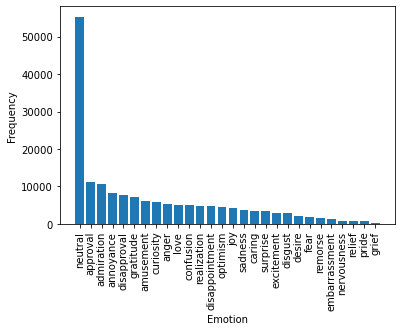

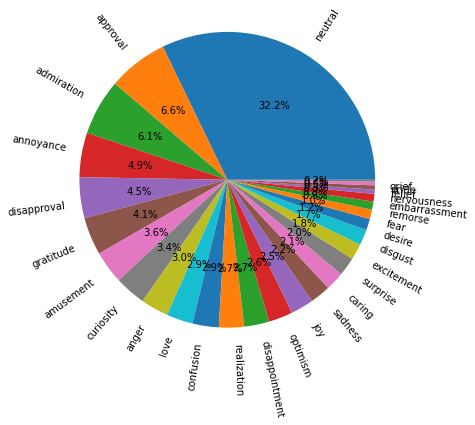

In [41]:
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(emotion.keys(),emotion)
plt.show()
e=[]
s=[]
for key,value in emotion.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.show()

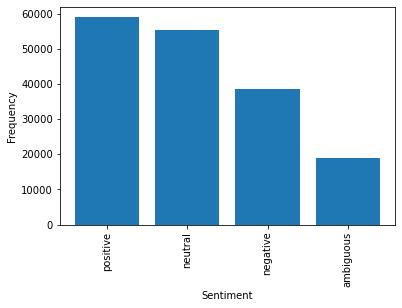

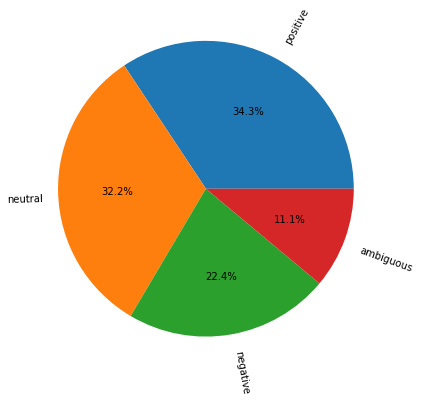

In [42]:
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.bar(sentiment.keys(),sentiment)
plt.show()

e=[]
s=[]
for key,value in sentiment.items():
    e.append(key)
    s.append(value)
plt.pie(s,labels=e,rotatelabels=True,autopct='%0.1f%%',labeldistance=1.1,radius=1.7)
plt.show()

### 3.3 Compute the embedding of a Reddit post as the average of the embeddings of its words. If a word has no embedding in Word2Vec, skip it.

In [43]:
redditpositone=list_tokens[1]
print(redditpositone)

['That', 'game', 'hurt', '.']


In [44]:
vecter_list=[]
word_filtered_list=[]
vecter_list=[wordvec2model[word] for word in redditpositone if word in wordvec2model.index_to_key]

word_filtered_list=[word for word in redditpositone if word in wordvec2model.index_to_key]

df=pd.DataFrame.from_dict(dict(zip(word_filtered_list,vecter_list)),orient='index')
json.dump(df.to_dict(), open("filteredlist_one_reddit_post.json", 'w'))
gj=pd.read_json("filteredlist_one_reddit_post.json")
dict_tokens=gj.to_dict()
gj.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
That,-0.138672,0.125977,0.326172,0.099609,-0.237305,0.014832,0.049805,-0.091797,0.205078,0.296875,...,-0.150391,0.013367,-0.242188,0.043213,-0.129883,-0.320312,0.126953,0.049561,0.253906,-0.181641
game,0.114746,0.052734,0.042969,0.004486,0.273438,0.071777,0.173828,-0.198242,0.020752,0.118652,...,-0.212891,0.043213,-0.139648,-0.011597,0.228516,0.170898,-0.010437,-0.094238,-0.172852,-0.052734
hurt,-0.003891,0.092773,-0.009277,0.061768,-0.100586,0.239258,0.104004,0.013977,0.183594,0.263672,...,0.196289,0.154297,-0.160156,-0.081543,-0.215820,0.078613,-0.363281,-0.065918,0.119141,-0.165039


In [45]:
average=[]
for x in range(0,wordvec2model.vector_size-1):
    k=0
    for j in range(0,len(dict_tokens[0])-1):
        k+=gj[x][j]
    average.append(k/len(dict_tokens[0]))
df=pd.DataFrame(average,columns=['average'])
df.T.head()

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,296,297,298
average,-0.007975,0.05957,0.123047,0.034698,0.012044,0.02887,0.074544,-0.09668,0.075277,0.138509,...,0.018738,-0.121094,0.01886,-0.127279,0.010539,0.032878,-0.049805,0.038839,-0.014893,0.027018


In [46]:
X_train, X_test, y_train, y_test = train_test_split(tokenizer,file[['emotion', 'sentiment']], test_size=0.2)


### 3.4 Compute and display the overall hit rates of the training and test sets (i.e. the % of words in the Reddit posts for which an embedding is found in Word2Vec).

In [47]:
def filter_by_word2vec(list_list,list_name):
    global y_train
    dumy=[]
    for i in range(0,300):
        dumy.append(0)
        
    
    df=pd.DataFrame()
    print(len(list_list))
    vocab=wordvec2model.index_to_key
    print(len(vocab))
    count=0
    vecter_list1=[]
    word_filtered_list1=[]
    if(os.path.exists(f'filteredlist_reddit_post_{list_name}.json')):
       
        print('openfile,filtered list')
    else:
        for words in list_list:
            linetext=[]
            count+=1
            print("search embeddings, till complete {:0.1%}".format(count/len(list_list)),end='\r')
            for word in words:
                if word in vocab:
                    linetext.append(word)
            word_filtered_list1.append(linetext)
         
        for words in word_filtered_list1:
            linevec=[]
            for word in words:
                linevec.append(wordvec2model[word])
            vecter_list1.append(np.mean(linevec,axis=0))
            
        for i in range(len(vecter_list1)-1):
            if vecter_list1[i].shape == (300,):
                continue
            else:
                print(f'findimpuretyat:{i}')
                vecter_list1[i]=dumy
                
        df=pd.DataFrame(vecter_list1)
        json.dump(df.to_dict(), open(f"filteredlist_reddit_post_{list_name}.json", 'w'))
        df.head(5)

In [48]:
print(y_train.shape)
selectlist2=X_test
filter_by_word2vec(selectlist2,"X_test")

(137456, 2)
34364
3000000
openfile,filtered list


In [49]:
selectlist=X_train
filter_by_word2vec(selectlist,"X_train")

137456
3000000
openfile,filtered list


In [50]:
df_train=pd.read_json(f"filteredlist_reddit_post_X_train.json")
X_train_filtered=df_train.values.tolist()
df_test=pd.read_json(f"filteredlist_reddit_post_X_test.json")
X_test_filtered=df_test.values.tolist()
df_train.head(167)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.074473,-0.028224,0.074883,0.114950,0.018596,-0.039480,0.035522,-0.086110,0.110636,0.191630,...,-0.043921,-0.021790,-0.115000,0.048299,-0.070190,-0.025116,0.087463,-0.048940,0.058675,-0.078451
1,0.014440,0.015371,0.017170,0.134499,-0.005157,-0.044666,0.007108,-0.002695,-0.012939,0.071800,...,-0.103782,0.060630,-0.107522,0.072731,-0.002595,-0.015055,-0.031788,-0.057085,0.021905,0.015514
2,0.036253,0.034479,0.020712,0.057836,-0.040987,0.005086,0.062035,-0.061710,0.071849,0.073953,...,-0.062227,0.044512,-0.101859,0.026827,-0.067433,-0.072546,0.017973,-0.067028,0.083396,-0.000659
3,0.081573,0.032275,0.011780,0.012614,0.049988,-0.062421,0.078786,-0.055603,0.042247,0.087911,...,0.018936,0.004873,-0.199448,0.019526,-0.107086,-0.065796,0.001322,-0.048716,0.020060,-0.004415
4,-0.058746,0.003027,0.079639,-0.064929,-0.094131,0.052441,0.093359,-0.186035,0.204395,-0.004199,...,-0.107324,0.028833,-0.044519,0.004053,0.019580,-0.069885,0.054541,-0.124170,0.070972,-0.101758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.045611,0.086123,0.068787,0.121012,-0.072141,-0.009472,-0.039368,-0.064314,0.066703,0.074498,...,-0.036669,0.041453,-0.127465,-0.012442,-0.044080,-0.080991,-0.006252,-0.078102,0.015639,-0.010667
163,0.125570,-0.040360,-0.012533,0.116130,-0.122945,-0.013774,0.140462,-0.100265,0.084005,-0.003825,...,-0.004232,0.030355,-0.016154,0.125142,-0.043355,0.055420,0.069661,-0.029541,0.043416,-0.053650
164,0.053113,0.023563,0.040924,0.080277,-0.077756,-0.024334,0.038854,-0.098334,0.040500,0.036540,...,-0.067505,0.057959,-0.112462,0.040753,-0.100141,-0.025770,0.013820,-0.025087,0.057831,-0.034348
165,0.093315,0.053682,0.089752,0.135818,-0.005569,-0.055214,0.048954,-0.094727,0.062904,0.149918,...,-0.012184,0.063044,-0.187439,-0.005104,-0.109085,-0.053651,-0.016838,-0.065147,-0.007571,-0.014923


In [51]:
count_total=0
for words1 in X_train:
    for word1 in words1:
        count_total+=1
        
print()
print(count_total)


2114574


In [52]:
print('hit rate of X_train is: {:0.1%}'.format(len(vecter_list)/count_total))

hit rate of X_train is: 0.0%


In [53]:
dumy=[]
for i in range(0,300):
    dumy.append(0)
dumy1=[]
for i in range(0,300):
    dumy1.append(1)
for j in range(len(X_train_filtered)-1):
    if X_train_filtered[j] ==dumy:
        print('find dumy')
        X_train_filtered[j]=dumy1
       
        

find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy
find dumy


In [54]:
count_tota2=0
for words2 in X_test:
    for word2 in words2:
        count_tota2+=1
        
print()
print(count_tota2)
print('hit rate of X_test is: {:0.1%}'.format(len(vecter_list)/count_tota2))


527554
hit rate of X_test is: 0.0%


### 3.5 Train a Base-MLP: a Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.


In [55]:
performance_data = []
def train_model_vec2(model, model_name,label,X_train_in,Y_train_in):
    
    start=time.time()
    print(f'{label} train {label} start: {start}')
        
    if (os.path.exists(f'Googlemodel/{model_name}_{label}_model.pickle')):
        picklefile = open(f'Googlemodel/{model_name}_{label}_model.pickle','rb')
        model = pickle.load(picklefile)
        print(f"success load pretrainedmodel: trainedmodels/{model_name}_{label}_model.pickle")
    else:
        model = model.fit(X_train_in, Y_train_in)
        with open(f'Googlemodel/{model_name}_{label}_model.pickle','wb') as f:
            pickle.dump(model, f)

        pickle_in = open(f'Googlemodel/{model_name}_{label}_model.pickle','rb')
        model = pickle.load(pickle_in)

    end=time.time()
    print(f'{label} train {label} end: {end} take time:{end-start}')
      

In [56]:
def performance_data_show2(train_y,predict_y,model_type,model_name,y_name):
    print(f"F1 Score (W): {sklearn.metrics.f1_score(y_true=train_y,y_pred= predict_y,average='weighted')}")
    print(f"F1 Score (M): {sklearn.metrics.f1_score(y_true=train_y,y_pred= predict_y,average='macro')}")
    
    print(f"Accuracy: {sklearn.metrics.accuracy_score(y_true=train_y,y_pred= predict_y)}")
    print(f"Precision (W): {sklearn.metrics.precision_score(y_true=train_y,y_pred= predict_y, average='weighted')}")
    
    confusion_matrix(y_true=train_y,y_pred= predict_y)
    print(classification_report(y_true=train_y,y_pred= predict_y, zero_division='warn'))
    cmp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix(y_true=train_y,y_pred= predict_y))
    fig, ax = plt.subplots(figsize=(14,14))
    cmp.plot(ax=ax,cmap='Blues_r',colorbar='coolwarm')
    plt.savefig(f"plotpic/{model_type}_{model_name}_{y_name}.jpg")

In [57]:
classifier=MLPClassifier(max_iter=20)
predict_emotion=train_model_vec2(classifier,"mplclassifier","emotion",X_train_filtered,y_train['emotion'])

emotion train emotion start: 1666553677.619993
success load pretrainedmodel: trainedmodels/mplclassifier_emotion_model.pickle
emotion train emotion end: 1666553677.7011826 take time:0.08118963241577148


In [58]:
print(y_train['emotion'])

142943       sadness
57609        neutral
156428       neutral
99056          anger
34720        neutral
             ...    
102914       neutral
76251     excitement
71509        neutral
84171        neutral
115158        caring
Name: emotion, Length: 137456, dtype: object


test for emotion:
F1 Score (W): 0.1584868141973371
F1 Score (M): 0.017956101890741316
Accuracy: 0.3214992433942498
Precision (W): 0.1275025721043025
                precision    recall  f1-score   support

    admiration       0.03      0.00      0.00      2099
     amusement       0.12      0.00      0.00      1258
         anger       0.00      0.00      0.00      1074
     annoyance       0.04      0.00      0.00      1633
      approval       0.14      0.00      0.01      2276
        caring       0.00      0.00      0.00       670
     confusion       0.00      0.00      0.00      1012
     curiosity       0.00      0.00      0.00      1181
        desire       0.00      0.00      0.00       434
disappointment       0.00      0.00      0.00       955
   disapproval       0.08      0.00      0.00      1514
       disgust       0.00      0.00      0.00       570
 embarrassment       0.00      0.00      0.00       274
    excitement       0.00      0.00      0.00       604
          

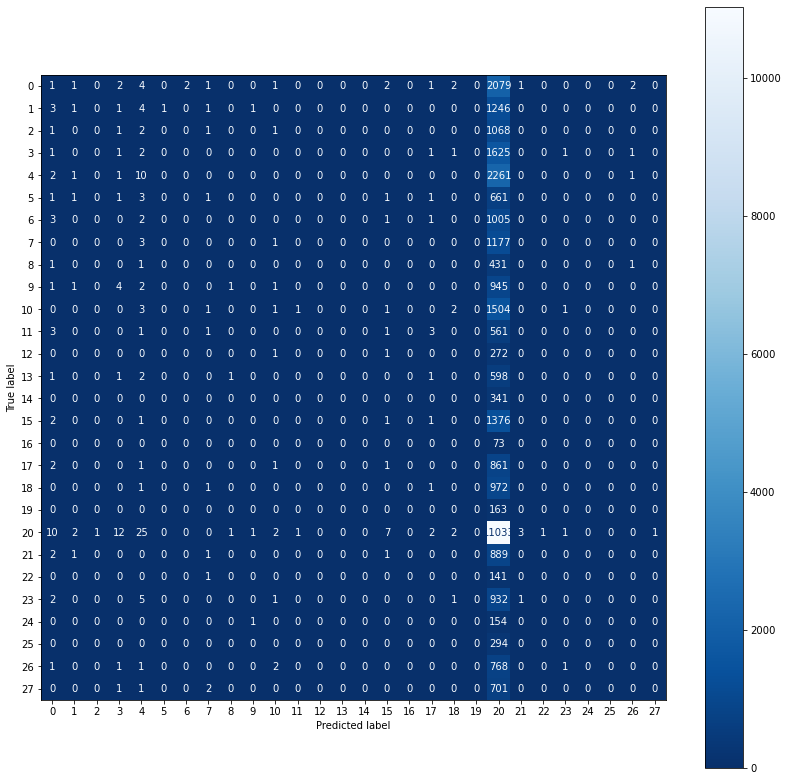

In [59]:
model_typeN='Googlemodel'
model_nameN='mplclassifier'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test_filtered)
print(f'test for {y_name}:')
performance_data_show2(y_test['emotion'],y_pred,model_typeN,model_nameN,y_name)

## 3.6 Train a Top-MLP: a better performing Multi-Layered Perceptron found with whatever hyperparameters you want.

In [60]:
classifier=MLPClassifier(activation= 'relu',solver= 'adam',max_iter=10)
predict_emotion=train_model_vec2(classifier,"mplclassifier2","emotion",X_train_filtered,y_train['emotion'])

emotion train emotion start: 1666553683.5047228
success load pretrainedmodel: trainedmodels/mplclassifier2_emotion_model.pickle
emotion train emotion end: 1666553683.543355 take time:0.03863215446472168


test for emotion:
F1 Score (W): 0.15814862191377188
F1 Score (M): 0.017747242434440282
Accuracy: 0.32216854848096843
Precision (W): 0.13504128310199612
                precision    recall  f1-score   support

    admiration       0.08      0.00      0.00      2099
     amusement       0.00      0.00      0.00      1258
         anger       0.17      0.00      0.00      1074
     annoyance       0.00      0.00      0.00      1633
      approval       0.09      0.00      0.00      2276
        caring       0.00      0.00      0.00       670
     confusion       0.00      0.00      0.00      1012
     curiosity       0.00      0.00      0.00      1181
        desire       0.00      0.00      0.00       434
disappointment       0.00      0.00      0.00       955
   disapproval       0.33      0.00      0.00      1514
       disgust       0.00      0.00      0.00       570
 embarrassment       0.00      0.00      0.00       274
    excitement       0.00      0.00      0.00       604
       

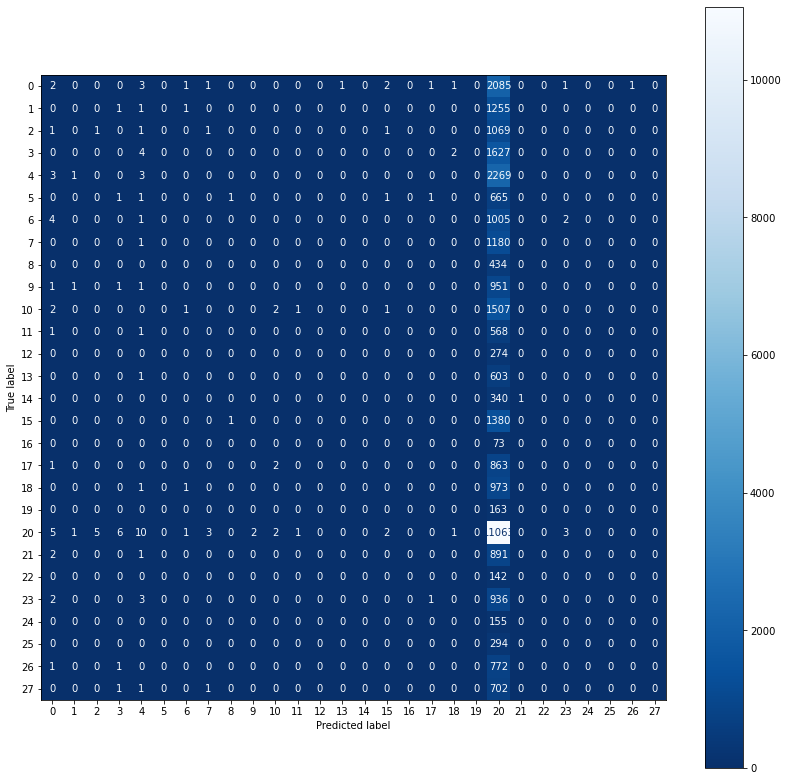

In [61]:
model_typeN='Googlemodel'
model_nameN='mplclassifier2'
y_name='emotion'
pickle_in = open(f'{model_typeN}/{model_nameN}_{y_name}_model.pickle','rb')
model = pickle.load(pickle_in)
y_pred = model.predict(X_test_filtered)
print(f'test for {y_name}:')
performance_data_show2(y_test['emotion'],y_pred,model_typeN,model_nameN,y_name)